In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import tensorflow as tf
from tensorflow.keras import layers

class Gaussian():
    ''' 一般次元のガウス分布 '''
    def __init__(self, mus, sigmas):
        self.mus = np.array(mus); self.sigmas = np.array(sigmas)
        self.cov = np.diagflat(sigmas)
        self.type= ''
    def sample(self, N):
        return np.random.multivariate_normal(self.mus, self.cov, N)
    
def plot_scatter(ax, func, center=None, mesh=10):
    mu_x = np.linspace(-1,6, mesh)
    mu_y = np.linspace(-.2,.5, mesh)
    mu_x, mu_y = np.meshgrid(mu_x, mu_y)
    mu_xy = np.concatenate([mu_x.reshape(mesh,mesh,1), mu_y.reshape(mesh,mesh,1)], axis=2)
    if center is not None:
        cmap = 'Blues'; color='blue'# empirical error
        title= 'L'
    else:
        center = p.mus
        cmap = 'Reds'; color='red' # generalization error
        title= r'$D_{KL}$'
    out = np.array([func(mu, center) for mu in mu_xy.reshape(mesh**2, 2)]).reshape(mesh, mesh)
    
    ax.set_xlim(-1, 6); ax.set_ylim(-.2, .5)
    ax.set_title(title, fontsize=15, color=color)
    ax.contourf(mu_x, mu_y, out, 20, alpha=0.9, cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap); sm.set_array(out)
    return sm

def plot_D_and_L(fig, X, func, D=None):
    sm1 = plot_scatter(ax=fig.axes[0], func=func); sm2 = plot_scatter(ax=fig.axes[1], func=func, center=X)
    fig.axes[1].scatter(X[:,0], X[:, 1], label='data for L')
    if D is not None:
        fig.axes[1].scatter(D[:,0], D[:, 1], color='blue', alpha=0.3, marker="x", label='all data')
    fig.axes[1].legend()
    fig.colorbar(sm1, ax=fig.axes[0]); fig.colorbar(sm2, ax=fig.axes[1])

def plot_trajectory(ax, muss_np):
    lines = np.concatenate([muss_np[:-1,0,:], muss_np[1:,0,:]], axis=1).reshape(-1, 2, 2)
    lc = mc.LineCollection(lines, linewidths=2, color='black', alpha=0.5)
    ax.add_collection(lc)
    ax.scatter(muss_np[:,0,0], muss_np[:,0,1], marker=".", color='black', label=r"$\theta$")
    ax.legend(fontsize=15)
    
def plot_D_and_L_and_trajectory(p, X, muss_np, func, D=None):
    fig=plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
    plot_D_and_L(fig, X, func, D)
    plot_trajectory(ax1, muss_np)
    plot_trajectory(ax2, muss_np)
    plt.show()

## 3-3. 勾配学習

### ニュートン法
まず1節で挙げた例のように、与えられたデータ $\mathcal{D}_N = \{({\bf x}_n, {\bf y}_n )\}_{n=1,2, \dots, N}$ に対する負の対数ML度

$$ \left. \begin{array}{ll}
L({\theta}; \mathcal{D}_N) := -
\langle \log q_{\theta} ({\bf y}|{\bf x}) \rangle_{\hat{p}_N} =
\frac{1}{N} \sum_{n=1}^N
l \Big(
\langle {\bf y} \rangle_{q_\theta (\cdot | {\bf x}_n)}, {\bf y}_n
\Big)
\end{array} \right. $$

を最小化するパラメータ ${\theta}_\text{ML}$を$({\bf x}_n, {\bf y}_n)$ について閉じた形式で表すことができれば話は早いのですが、深層ニューラルネットだとモデルが複雑なためそのようなことはできなさそうです。そこで数値的な解法が主な手法になってきます。この手の数値解法で有名なのはニュートン法です。パラメータを一列に並べて

$$ \left. \begin{array}{ll}
\theta = (\theta^1, \theta^2, \dots, \theta^{\# \theta})
\end{array} \right. $$
とすると、$L(\theta; \mathcal{D}_N)$の最小値では
$$ \left. \begin{array}{ll}
0 = \frac{\partial L}{\partial \theta^\mu} (\theta_\text{ML}; \mathcal{D}_N)
\end{array} \right. $$

が満たされるはずです。情報を増やすために $\theta_\text{ML}$ の近くの $\theta$ がどのような条件を満たすか考えてみます。テイラー展開により

$$ \left. \begin{array}{ll}
0=
\frac{\partial L}{\partial \theta^\mu} (\theta_\text{ML}; \mathcal{D}_N)
\approx
\frac{\partial L}{\partial \theta^\mu} (\theta; \mathcal{D}_N)
+
\underbrace{ \frac{\partial^2 L}{\partial \theta^\mu \partial \theta^\nu}   (\theta ; \mathcal{D}_N) }_{=: H_{\mu \nu}(\theta ; \mathcal{D}_N)}
({\theta}_\text{ML}^\nu - {\theta}^\nu)
\end{array} \right. $$

を解いて
$$ \left. \begin{array}{ll}
{\theta}_\text{ML}^\nu
\approx
{\theta}^\nu -
(H(\theta; \mathcal{D}_N))^{-1} )^{\nu \mu}
\frac{\partial L}{\partial \theta^\mu} (\theta; \mathcal{D}_N)
\end{array} \right. $$

となります。この近似に基づいて

$$ \left. \begin{array}{ll}
{\theta}_{t+1}^\nu =
{\theta}_t^\nu-
(H(\theta_t; \mathcal{D}_N))^{-1} )^{\nu \mu}
\frac{\partial L}{\partial \theta^\mu} (\theta_t; \mathcal{D}_N)
\end{array} \right. $$

とするのがニュートン法です。しかし深層ニューラルネットの場合$\theta = \{ W_1, W_2, \dots, W_L\}$であり、各$W$は行列ですから、$\theta$はすごく多くのパラメータからなり、その場合$H(\theta)$は各パラメータの二階微分からなる行列となり、その逆行列$H(\theta)^{-1}$を求めなければなりません。サイズ$\#\theta \times \#\theta$の行列の逆行列を求めるには$\#\theta^3$回の計算が必要です：

In [3]:
import time

def time_for_calculating_inverse_random(size):
    H = np.random.rand(size**2).reshape(size, size)
    t1 = time.time(); inv = np.linalg.inv(H); t2 = time.time()
    return t2-t1

def plot_time_for_inv(*ns, size0=1000, size1=1500):
    times = []; sizes = np.arange(size0, size1, 50)
    for size in sizes:
        times.append(time_for_calculating_inverse_random(size)) # measuring time here
    plt.xlabel("log(size)", fontsize=15); plt.ylabel("log(time)", fontsize=15)
    plt.plot(np.log(sizes), np.log(times), "o-", label='time for inv(H)') # log(size)-log(time) plot
    for n in ns:
        plt.plot(np.log(sizes), n*(np.log(sizes)-np.log(sizes[0])) + np.log(times[0]), "-", label='%d log(size)'%n)
    plt.legend(fontsize=15); plt.show()

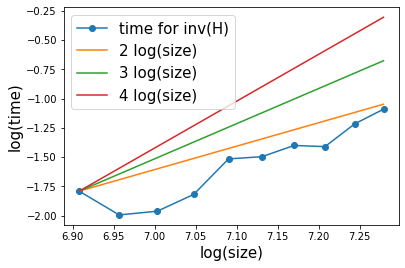

In [4]:
plot_time_for_inv(2,3,4)

>例えば掃き出し法を使うと、対角行列を1にするのに$\#\theta$回の基本変形(行を定数倍)、そこから非対角成分$\#\theta^2 - \#\theta$個を消去するのに1回ずつの基本変形が必要なので、合計で$\# \theta^2$回の基本変形を要します。基本変形はある行や列を一挙に扱うので1回あたり$\#\theta$回の演算を行う必要があるため、演算回数は$\# \theta^2 \times \# \theta = \# \theta^3$となるわけです。
ちなみに掃き出し法ではなくクラメルの公式(余因子行列による公式)を用いると余因子行列の計算に行列式の計算が入り$\#\theta !$くらいのオーダーになってしまうようです。

ので、例えば1節で紹介したようなCIFAR-10分類のResNetモデルだと$19,400,000^3$回（！）の計算を毎回の更新で計算せねばならず、現実的ではありません。

### 勾配降下法
ニュートン法をよく見てみると、経験誤差 $L$ を減らすのは負の微分値で更新している部分で、$H(\theta)^{-1}$はその更新度合いを表しているように見えてきます。そこでより単純に小さな実数 $\epsilon$ を使って、

$$ \left. \begin{array}{ll}
\theta_{t+1}^\mu=
\theta_t^\mu-
\epsilon
\frac{\partial L}{\partial \theta^\mu} (\theta_t ; \mathcal{D}_N)
\end{array} \right. $$

としても、定性的な性質は変わらないように思えます。これを勾配降下法といいます。$\epsilon$ は **学習率(learning rate)** と呼ばれます。

#### 数値実験
深層ニューラルネットワークでの学習は後にして、経過観察のしやすい、

$$
p(x) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{- \frac{(x - \mu_x)}{2 \sigma_x^2} - \frac{(y - \mu_y)}{2 \sigma_y^2}}, \quad  [\mu_x, \mu_y] = [4, 0.25], \quad [\sigma_x, \sigma_y]=[1/2,1/10]
$$

をデータ $\{{\bf x}_n = (x,y)_n \}$ を生成する答えの分布とします

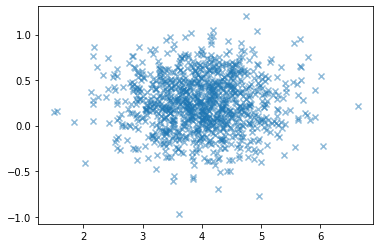

In [5]:
p = Gaussian([4,.25], [1/2,1/10])
X = p.sample(1000)
plt.scatter(X[:,0], X[:,1], alpha=0.5, marker="x"); plt.show()

この $p$ からのサンプル $\{ {\bf x_n} \}_{n=1,2, \dots, N}$ から、分散は一致しているが平均がパラメータになったモデル

$$
q_{\theta_x, \theta_y}(x, y) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{- \frac{(x - \theta_x)}{2 \sigma_x^2} - \frac{(y - \theta_y)}{2 \sigma_y^2}}, \quad [\sigma_x, \sigma_y]=[1/2,1/10]
$$

を学習することを考えます。このとき、

$$
\left\{ \begin{array}{ll}
{\color{red}{D_{KL}(p\|q_\theta)}} = \frac{1}{2}\Big( \frac{(\theta_x - \mu_x)^2}{\sigma_x^2} + \frac{(\theta_y - \mu_y)^2}{\sigma_y^2} \Big)
\\
{\color{blue}{\frac{- \log P_N(\theta)}{N}}} = \underbrace{\frac{1}{N} \sum_{n=1}^N \frac{1}{2}\Big( \frac{(\theta_x - x_n)^2}{\sigma_x^2} + \frac{(\theta_y - y_n)^2}{\sigma_y^2} \Big)}_{L} + (const)
\end{array} \right.
$$

でした。それぞれの誤差は分母に分散があるため二乗誤差ではなく、tensorflowの実装では足りません。近いものが`f = tf.keras.losses.MeanSquaredError`で $f({\bf x}_1, {\bf x}_2) = \frac{1}{2} \Big( (x_1 - x_2)^2 + (y_1 - y_2)^2 \Big)$ なので、これを使って

$$
F({\bf x}_1, {\bf x}_2) = f({\bf x}_1/{\bf \sigma}, {\bf x}_2/{\bf \sigma}) = \frac{1}{2} \Big( (\frac{x_1 - x_2}{\sigma_x})^2 + (\frac{y_1 - y_2}{\sigma_y})^2 \Big)
$$

を作っておきます：

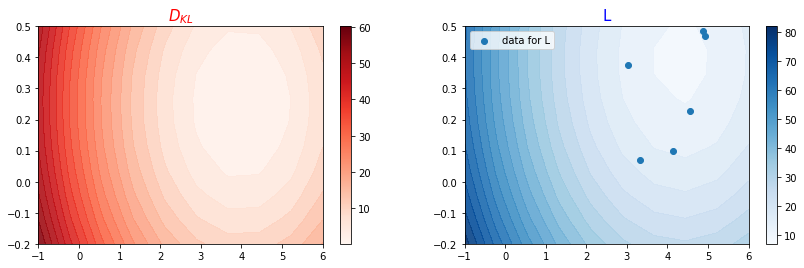

In [6]:
f = tf.keras.losses.MeanSquaredError(); sigmas = p.sigmas.reshape(1, 2)
def F(x1, x2):
    return f(x1/sigmas, x2/sigmas)
    
X = p.sample(10)
fig = plt.figure(figsize=(14, 4)); fig.add_subplot(121); fig.add_subplot(122)
plot_D_and_L(fig, X, func=F); plt.show()

汎化誤差と経験誤差の違いが見て取れます。経験誤差 $L$ を用いてモデルを勾配降下法で学習させてみるのに、まず

$$
\mathcal{D}_N=\{{\bf x}_n \}_{n=1,2,\dots, N}, \quad L = \frac{1}{N} \sum_{n=1}^N F({\bf x}_n, {\bf \theta})
$$

ですので、ここから一回あたりの

$$
\theta_{t+1}^\mu=
\theta_t^\mu-
\epsilon
\frac{\partial L}{\partial \theta^\mu} (\theta_t ; \mathcal{D}_N)
$$

の更新を実装する関数を書きます。以下やや高度な実装の解説をしますが、この節の初めにデモンストレーションしたように、もっと楽な書き方もできるので、必須ではないです。ただし、tensorflow eager mode の基本ルールなので、覚えておいて損はないと思います。

#### 学習モデルを作る
今回は $q_{\theta_x, \theta_y}(x, y) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{- \frac{(x - \theta_x)}{2 \sigma_x^2} - \frac{(y - \theta_y)}{2 \sigma_y^2}}$ をモデルとして、${\bf \theta}=(\theta_x, \theta_y)$ を調整します。ただし、誤差関数がわかっているので、確率分布 $q$ を実装する必要はなく、パラメータ ${\bf \theta}$ を実装すれば十分でしょう：

In [7]:
class Parameters(layers.Layer):
    def __init__(self, dim=2):
        super(Parameters, self).__init__()
        init = tf.random_normal_initializer()
        self.mus = tf.Variable(initial_value=init(shape=(1, dim),dtype='float32'),trainable=True)
    def __call__(self):
        return self.mus

`(1, dim)`の形のtensorflowに則った学習用パラメータクラスを作りました。`self.mus`がパラメータ ${\bf \theta}_t$ です：

In [8]:
model = Parameters()
model() # 値はガウシアンで初期化

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0.01243253, 0.02438724]], dtype=float32)>

こんな感じで、`hoge=Parameters()`でオブジェクトが作れて、`hoge()`と唱えるとパラメータ $\theta = (\theta_x, \theta_y)$ を吐き出してくれます。

#### 微分計算
このパラメータに対し例えば関数として $\theta_x + \theta_y$ を実装すると：

In [9]:
θ = model()
loss_value = θ[:, 0] + θ[:, 1]
loss_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03681977], dtype=float32)>

この関数の微分値は以下のように計算できます：

In [10]:
with tf.GradientTape() as tape:
    θ = model()
    loss_value = θ[:, 0] + θ[:, 1]
grads = tape.gradient(loss_value, model.trainable_variables) # grad に θ についての勾配が格納される
grads

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 1.]], dtype=float32)>]

$loss\_value = \theta_x + \theta_y$ の勾配 $\nabla_{\theta_x, \theta_y}loss\_value = [1, 1]$ がきちんと計算されているのがわかります。

#### 更新ステップ実装
これを `optimizer` オブジェクトというものに、`zip(grads, model.trainable_variables)`を食わせることで、自動的に ${\bf \theta}_t$ の更新をしてくれます：

In [11]:
def update(X, model, optimizer):
    ''' X:data w/ shape (N, 2)
        model:Gaussian
        optimizer:object for implementing gradient descent '''
    with tf.GradientTape() as tape:
        θ = model() # parameter θ を取得
        loss_value = F(X, θ) # 経験誤差を計算
    grads = tape.gradient(loss_value, model.trainable_variables) # grad に θ についての勾配が格納される
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # grad に基づき θ を更新

ここで `X` は $\mathcal{D}_N = \{ {\bf x_n} \}_{n=1,2, \dots, N}$ を $X = [{\bf x}_1, {\bf x}_2, \dots, {\bf x}_N]$ の(N, 2)形式にまとめたテンソルを表します。`optimizer`クラスは`tf.keras.optimizers`に実装されており、
- `tf.keras.optimizers.SGD(lr=0.02)`（これまで説明してきた素朴な勾配更新 $\epsilon=0.02$ ）
- `tf.keras.optimizers.Adam(lr=0.1)`（各更新時での勾配の情報をうまく使う勾配更新法。詳しく知りたい方は[元論文](https://arxiv.org/abs/1412.6980)をどうぞ）

などがあります。`Adam`は全更新回数 $T$としたとき、**regret**と呼ばれる更新の良さを測る量をオーダー $\frac{1}{\sqrt{T}}$ で下げてくれる理論保証があり、また、実際にもよく使われる深層学習ではデファクトスタンダードな更新法です。他にもたくさん更新法がありますので、気になる方は調べてみてください。ともかく、これで勾配降下法で学習させる準備が整いました。

#### 経験誤差 $L$ の勾配更新

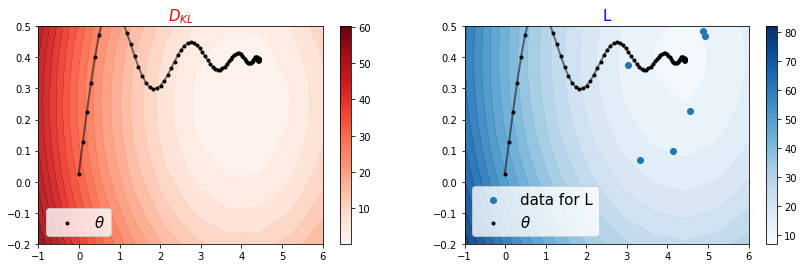

In [12]:
model = Parameters()
#optimizer=tf.keras.optimizers.SGD(lr=0.02, momentum=0.) # 今回、じつはSGDにとって難しい設定
optimizer=tf.keras.optimizers.Adam(lr=0.1)
muss = []
for t in range(100):
    muss.append(model.mus.numpy())
    update(X, model, optimizer)
plot_D_and_L_and_trajectory(p, X, np.array(muss), func=F)

右側の経験誤差を減らしにかかっているので、右側の最小点に向っていっているのがわかります。しかしこれは左側の汎化誤差の最小化になっていません。次はこれをどうにかする改良を考えます。

### オンライン学習
汎化の観点に立ち戻ってみると、小さくしたいのは経験誤差 $L$ ではなく汎化誤差 $D_{KL}$ なのでした。従って

$$ \left. \begin{array}{ll}
\theta_{t+1}^\mu=
\theta_t^\mu-
\epsilon
\frac{\partial }{\partial \theta^\mu} D_{KL}(p\|q_\theta)
\end{array} \right. $$

としたほうがより良いでしょう。

$$ \left. \begin{array}{ll}
D_{KL}(p\|q_\theta)= - S(p) 
\underbrace{- \langle \log q_\theta({\bf x}) \rangle_{p({\bf x})}}_{
\langle L(\theta; {\bf x}) \rangle_{p({\bf x})}
}
\end{array} \right. $$

だったので、結局

$$ \left. \begin{array}{ll}
\theta_{t+1}^\mu
&=
\theta_t^\mu-
\epsilon
\Big\langle
\underbrace{
\frac{\partial }{\partial \theta^\mu} 
L(\theta; {\bf x})
   }_{\text{gradient:= } g_\mu (\theta_t; {\bf x} )}
 \Big\rangle_{p({\bf x})}
\end{array} \right. $$

ができれば汎化が期待できるでしょう。しかし勾配の期待値 $\langle g_\mu (\theta_t; {\bf x} ) \rangle_{p({\bf x})}$ の計算にはデータ生成分布 $p$ による期待値計算が必要で、これは通常不可能です。代わりに **更新の度に毎回新しいサンプルデータ** $\{ {\bf x} \}_{n=1}^N$ によるサンプル平均でこれを近似する方法が考えられます。今回はおもちゃのデータとデータ生成確率 $p({\bf x})$ があるので、このことは簡単に実現できます：

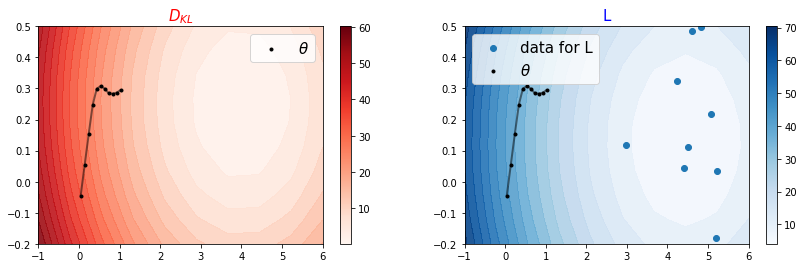

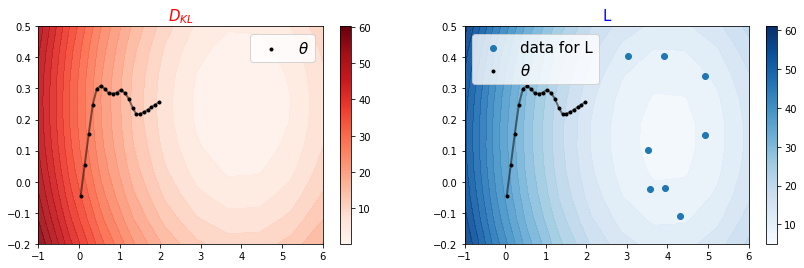

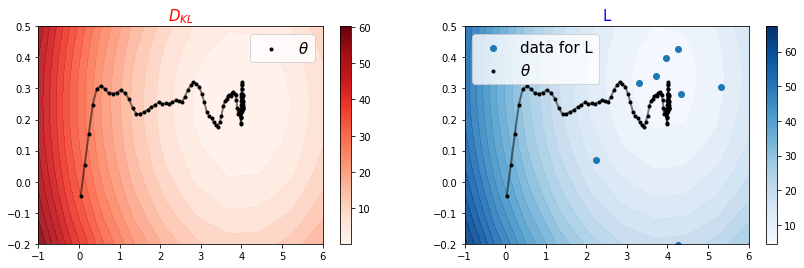

In [13]:
model = Parameters()
#optimizer=tf.keras.optimizers.SGD(lr=0.02, momentum=0.) # 今回、じつはSGDにとって難しい設定
optimizer=tf.keras.optimizers.Adam(lr=0.1)
muss = []
for t in range(100):
    X = p.sample(10) ## 毎回別のサンプルを取る
    muss.append(model.mus.numpy())
    update(X, model, optimizer)
    ### plot
    if t in [10, 20]:
        plot_D_and_L_and_trajectory(p, X, np.array(muss), func=F)
    ###
plot_D_and_L_and_trajectory(p, X, np.array(muss), func=F)

オンライン学習法を使うと、きちんと汎化誤差（左）の意味で最良のパラメータが減るのが確認できます。また、上の実行結果から、更新毎に経験誤差の形状が確率的に変動＝勾配も確率的に変動、していることが確認できます。こうしておくと十分多く更新すれば **大数の法則** から経験誤差のデータによる期待値＝汎化誤差を小さくすることが保証されるので嬉しいわけです。

### 確率的勾配降下法(Stochastic Gradient Descent)
オンライン学習では
- 毎回独立なデータを取ってこなければいけない

ですが、折角手に入れたデータを一度しか使わないのは、もったいない気もします。実際にはこの理想的な確率的勾配降下法を実行できる場合は少なく、単に一つのデータ

$$ 
\mathcal{D}_N =
\left\{ \begin{array}{ll}
 \Big\{ ({\bf x}_1, {\bf y}_1), ({\bf x}_2, {\bf y}_2), \dots, ({\bf x}_N, {\bf y}_N) \Big\} & supervised
 \\
 \Big\{ {\bf x}_1, {\bf x}_2, \dots, {\bf x}_N  \Big\} & unsupervised
\end{array} \right. $$

だけが与えられるケースも多いです。この場合でも学習プロセスを理想的なオンライン学習になるべく近づけようとしたのが、深層学習でよく使われる **確率的勾配降下法(Stochastic Gradient Descent, SGD)** です。例えばここにデータ

In [14]:
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

があるとします。$N=10$ で更に1次元スカラーで大したこと無いデータですが、この状況でオンライン学習のようなことをするやり方の一つが、$n<N$個の部分データをこの中からランダムに取ることです：

オンライン学習|擬オンライン学習
:---:|:---:
$\mathcal{D}_n \overset{sample}{\sim} p$|$\mathcal{D}_n \overset{random}{\subset} \mathcal{D}_N$

そこで上のデータからランダムに部分データを取るサブルーチンが必要です。`tf.data.Dataset`にそのような処理がまとまって実装されています：

In [15]:
def return_tf_batch(X, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.shuffle(len(X), reshuffle_each_iteration=False) 
    return dataset.batch(batch_size=batch_size).as_numpy_iterator()

batch = return_tf_batch(X, batch_size=3)
for minibatch in batch:
    print(minibatch)

[ 4  5 10]
[2 6 7]
[3 1 8]
[9]


各データは一回ずつしか出てきていない（＝**直和分解** $\oplus$になっている）ことに注意してください。これを用いて 確率的勾配降下法は例えば以下のような実装になります。
> 用語に関する注意：
>- データを小分けにした $\mathcal{D}_N = \mathcal{D}_{n}^{(1)} \oplus \mathcal{D}_{n}^{(2)} \oplus \dots \oplus \mathcal{D}_{n}^{(n/N)}$ のことを「バッチ」
>- 部分データ $\mathcal{D}_n^{(i)} \subset \mathcal{D}_N$ を「ミニバッチ」、$n$ を「バッチサイズ」
>- $\mathcal{D}_N$を何周したかの単位＝「世代(epoch)」
>- 全体で何回アップデートしたかの単位＝「反復回数(iteration)」
>
>等と呼ばれます。



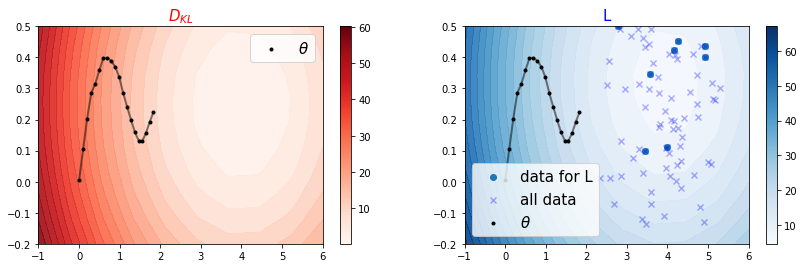

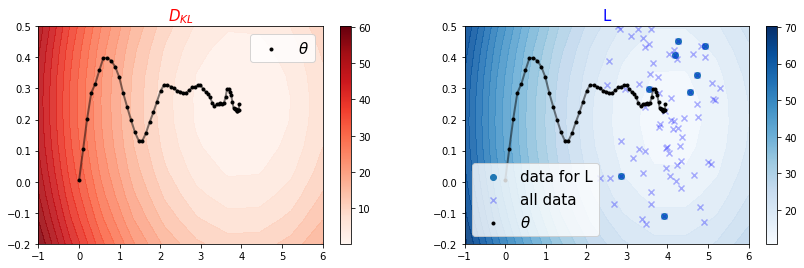

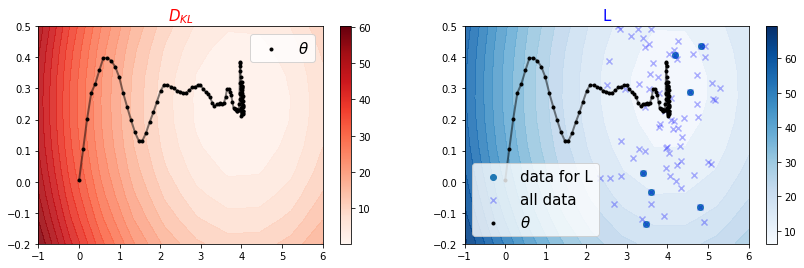

In [16]:
model = Parameters()
#optimizer=tf.keras.optimizers.SGD(lr=0.02, momentum=0.) # 今回、じつはSGDにとって難しい設定
optimizer=tf.keras.optimizers.Adam(lr=0.1)

muss = []
X = p.sample(100)
for epoch in range(10):
    batch = return_tf_batch(X, batch_size=10)
    for minibatch in batch:
        muss.append(model.mus.numpy())
        update(minibatch, model, optimizer)
    if epoch in [1, 5, 9]:
        plot_D_and_L_and_trajectory(p, minibatch, np.array(muss), func=F, D=X)

汎化誤差を減らす効果があるのがわかります。といっても、実のところここでの例では誤差関数が単純すぎるため、$N$ 一定で通常の経験誤差最小化（最尤法）よりもSGDの方が良いことは必ずしも言えません。実際上の例では $N=100$ としましたが、同じデータで経験誤差最小化でもきちんと汎化誤差は減るということをコメントしておきます。